# Import the data and required modules.

In [3]:
import pandas as pd
iris_data = pd.read_csv("iris.csv")
iris_data.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Look for missing data

In [5]:
iris_data = pd.read_csv('iris.csv', na_values=['NA'])

# Look at the distribution of our data — especially the outliers

Let's start by printing out some summary statistics about the data set.

In [6]:
iris_data.describe()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm
count,150.000000,150.000000,150.000000,145.000000
mean,5.644627,3.054667,3.758667,1.236552
std,1.312781,0.433123,1.764420,0.755058
min,0.055000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.700000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


We can see several useful values from this table. For example, we see that five petal_width_cm entries are missing.

# Visualize the data to check outliers and error

In [9]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

Next, let's create a <b>scatterplot matrix</b>. Scatterplot matrices plot the distribution of each column along the diagonal, and then plot a scatterplot matrix for the combination of each variable. They make for an efficient tool to look for errors in our data.

We can even have the plotting package color each entry by its class to look for trends within the classes.

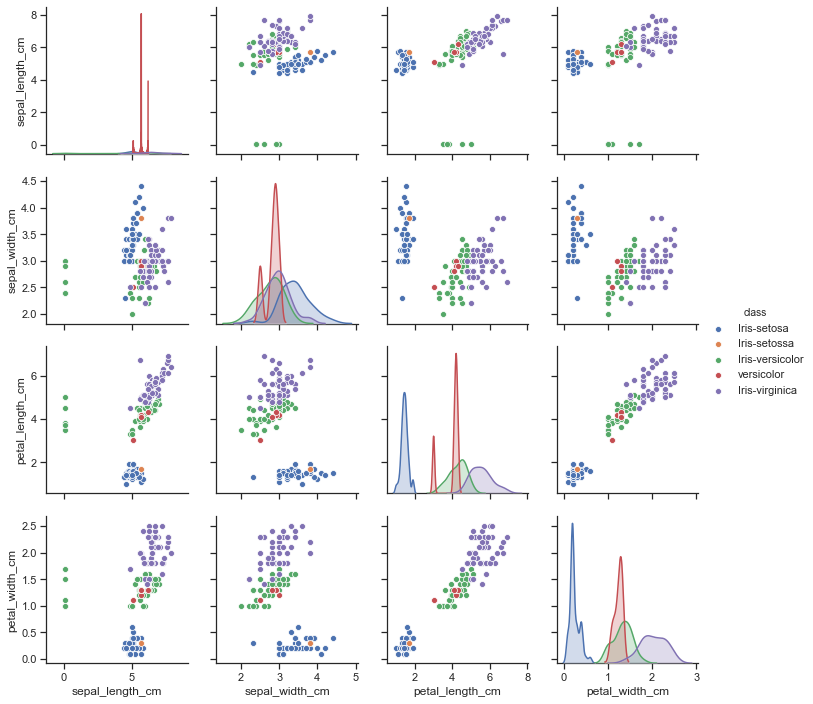

In [11]:
# We have to temporarily drop the rows with 'NA' values
# because the Seaborn plotting function does not know
# what to do with them
sns.set(style="ticks")
sns.pairplot(iris_data.dropna(), hue='class')

From the scatterplot matrix, we can already see some issues with the data set:

There are five classes when there should only be three, meaning there were some coding errors.

There are some clear outliers in the measurements that may be erroneous: one sepal_width_cm entry for Iris-setosa falls well outside its normal range, and several sepal_length_cm entries for Iris-versicolor are near-zero for some reason.

We had to drop those rows with missing values.

In all of these cases, we need to figure out what to do with the erroneous data. Which takes us to the next step...

# Step 3: Tidying the data

It sounds like one of them forgot to add Iris- before their Iris-versicolor entries. The other extraneous class, Iris-setossa, was simply a typo that they forgot to fix.

In [12]:
iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'

iris_data['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Much better! Now we only have three class types.

<b>Fixing Outliers</b>

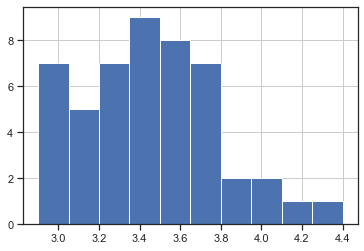

In [13]:
# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

The next data issue to address is the several near-zero sepal lengths for the Iris-versicolor rows. Let's take a look at those rows.

In [14]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
77,0.067,3.0,5.0,1.7,Iris-versicolor
78,0.060,2.9,4.5,1.5,Iris-versicolor
79,0.057,2.6,3.5,1.0,Iris-versicolor
80,0.055,2.4,3.8,1.1,Iris-versicolor
81,0.055,2.4,3.7,1.0,Iris-versicolor


All of these near-zero sepal_length_cm entries seem to be off by two orders of magnitude, as if they had been recorded in meters instead of centimeters.

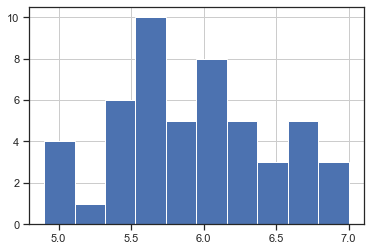

In [15]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0),
              'sepal_length_cm'] *= 100.0

iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].hist()

We had to drop those rows with missing values.

In [16]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
7,5.0,3.4,1.5,NaN,Iris-setosa
8,4.4,2.9,1.4,NaN,Iris-setosa
9,4.9,3.1,1.5,NaN,Iris-setosa
10,5.4,3.7,1.5,NaN,Iris-setosa
11,4.8,3.4,1.6,NaN,Iris-setosa


It's not ideal that we had to drop those rows, especially considering they're all Iris-setosa entries. Since it seems like the missing data is systematic — all of the missing values are in the same column for the same Iris type — this error could potentially bias our analysis.

One way to deal with missing data is <b>mean imputation</b>: If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measurement.

Let's see if we can do that here.

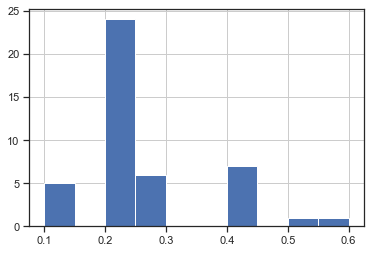

In [17]:
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].hist()

Most of the petal widths for Iris-setosa fall within the 0.2-0.3 range, so let's fill in these entries with the average measured petal width.

In [18]:
average_petal_width = iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

In [19]:
iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'].isnull()),
              'petal_width_cm'] = average_petal_width

In [20]:
iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'] == average_petal_width)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
7,5.0,3.4,1.5,0.25,Iris-setosa
8,4.4,2.9,1.4,0.25,Iris-setosa
9,4.9,3.1,1.5,0.25,Iris-setosa
10,5.4,3.7,1.5,0.25,Iris-setosa
11,4.8,3.4,1.6,0.25,Iris-setosa


In [21]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


Great! Now we've recovered those rows and no longer have missing data in our data set.

<b>Note:</b> If you don't feel comfortable imputing your data, you can drop all rows with missing data with the dropna() call:

    iris_data.dropna(inplace=True)

After all this hard work, we don't want to repeat this process every time we work with the data set. Let's save the tidied data file as a separate file and work directly with that data file from now on.

In [22]:
iris_data.to_csv('iris-data-clean.csv', index=False)

In [23]:
iris_data_clean = pd.read_csv('iris-data-clean.csv')

Now, let's take a look at the scatterplot matrix now that we've tidied the data.

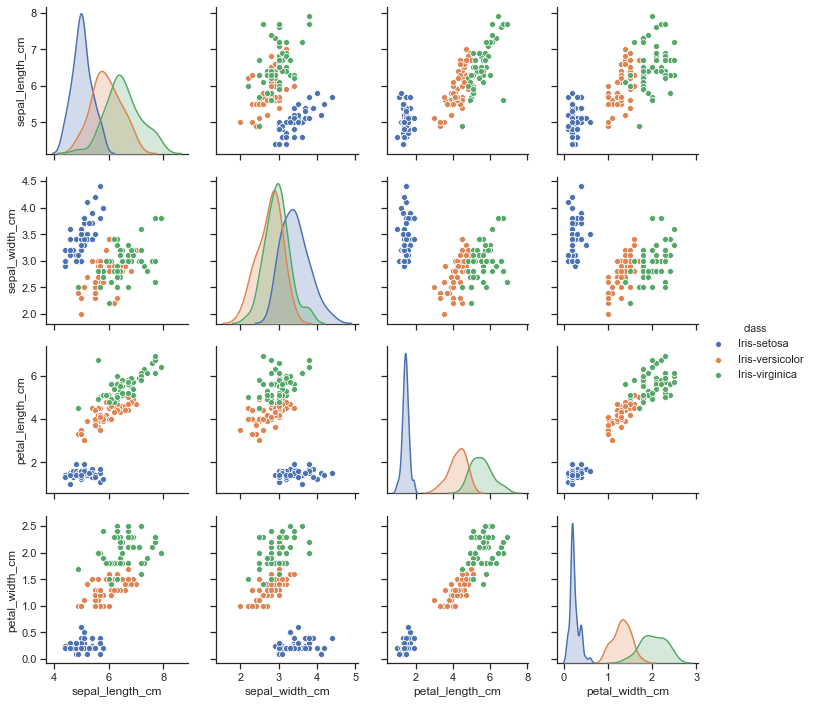

In [24]:
sns.pairplot(iris_data_clean, hue='class')

The general takeaways here should be:

    1. Make sure your data is encoded properly

    2. Make sure your data falls within the expected range, and use domain knowledge whenever possible to define that 
    expected range

    3. Deal with missing data in one way or another: replace it if you can or drop it

    4.Never tidy your data manually because that is not easily reproducible

    5. Use code as a record of how you tidied your data

    6. Plot everything you can about the data at this stage of the analysis so you can visually confirm everything 
    looks correct

# Testing our data using assert statements

In [25]:
# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3

In [26]:
# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data_clean.loc[iris_data_clean['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

In [27]:
# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

In [30]:
# assert 1 == 2

# Exploratory analysis

Now after spending entirely too much time tidying our data, we can start analyzing it!

Exploratory analysis is the step where we start delving deeper into the data set beyond the outliers and errors. We'll be looking to answer questions such as:

1. How is my data distributed?
2. Are there any correlations in my data?
3. Are there any confounding factors that explain these correlations?

This is the stage where we plot all the data in as many ways as possible. Create many charts, but don't bother making them pretty — these charts are for internal use.

Let's return to that scatterplot matrix that we used earlier.

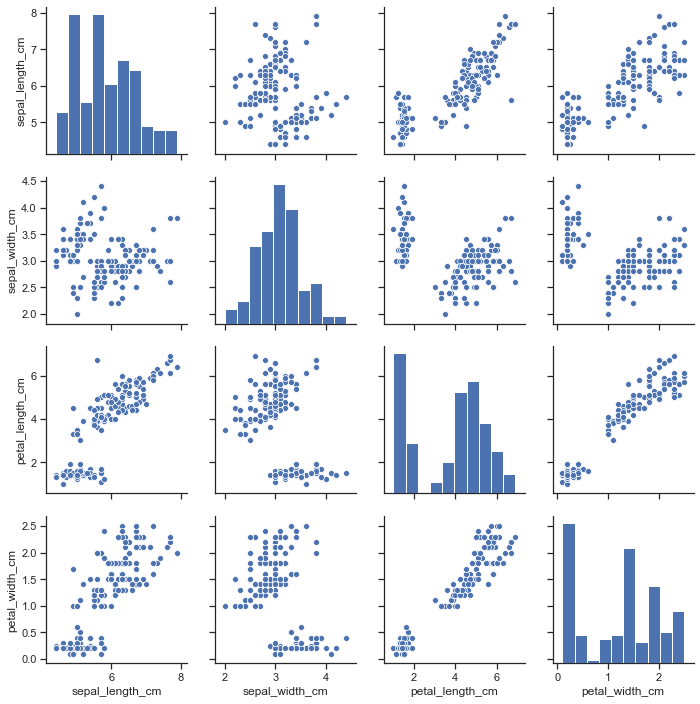

In [31]:
sns.pairplot(iris_data_clean)

Our data is normally distributed for the most part, which is great news if we plan on using any modeling methods that assume the data is normally distributed.

There's something strange going on with the petal measurements. Maybe it's something to do with the different Iris types. Let's color code the data by the class again to see if that clears things up.

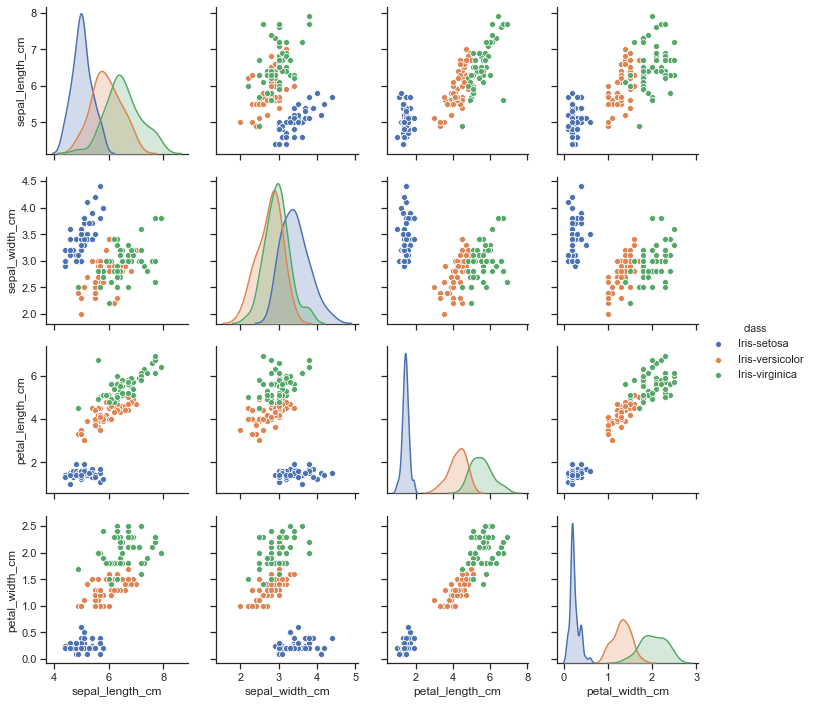

In [33]:
sns.pairplot(iris_data_clean, hue='class')

Sure enough, the strange distribution of the petal measurements exist because of the different species. This is actually great news for our classification task since it means that the petal measurements will make it easy to distinguish between Iris-setosa and the other Iris types.

Distinguishing Iris-versicolor and Iris-virginica will prove more difficult given how much their measurements overlap.

There are also correlations between petal length and petal width, as well as sepal length and sepal width. This is to be expected: Longer flower petals also tend to be wider, and the same applies for sepals.

We can also make <b>violin plots</b> of the data to compare the measurement distributions of the classes. Violin plots contain the same information as box plots, but also scales the box according to the density of the data.

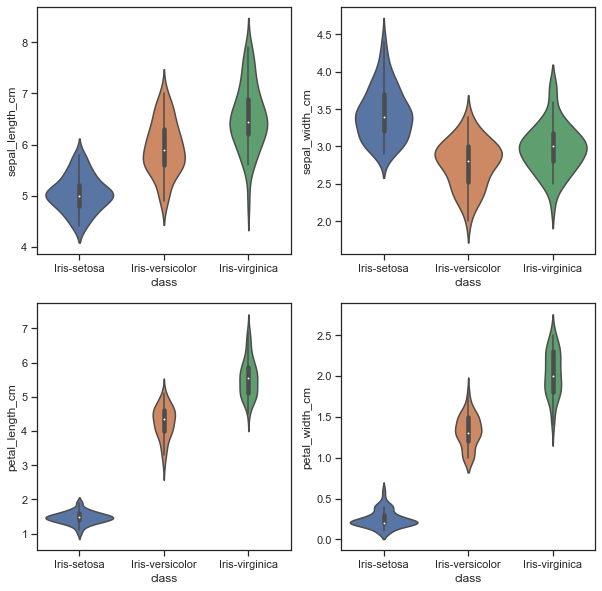

In [34]:
plt.figure(figsize=(10, 10))

for column_index, column in enumerate(iris_data_clean.columns):
    if column == 'class':
        continue
    plt.subplot(2, 2, column_index + 1)
    sns.violinplot(x='class', y=column, data=iris_data_clean)

## Classification

Assured that our data is now as clean as we can make it — and armed with some cursory knowledge of the distributions and relationships in our data set — it's time to make the next big step in our analysis: Splitting the data into training and testing sets.

A <b>training set</b> is a random subset of the data that we use to train our models.

A <b>testing set</b> is a random subset of the data (mutually exclusive from the training set) that we use to validate our models on unforseen data.

Especially in sparse data sets like ours, it's easy for models to <b>overfit</b> the data: The model will learn the training set so well that it won't be able to handle most of the cases it's never seen before. This is why it's important for us to build the model with the training set, but score it with the testing set.

Note that once we split the data into a training and testing set, we should treat the testing set like it no longer exists: We cannot use any information from the testing set to build our model or else we're cheating.

Let's set up our data first.

In [36]:
iris_data_clean = pd.read_csv('iris-data-clean.csv')

# We're using all four measurements as inputs
# Note that scikit-learn expects each entry to be a list of values, e.g.,
# [ [val1, val2, val3],
#   [val1, val2, val3],
#   ... ]
# such that our input data set is represented as a list of lists

# We can extract the data in this format from pandas like this:
all_inputs = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

# Similarly, we can extract the class labels
all_labels = iris_data_clean['class'].values

# Make sure that you don't mix up the order of the entries
# all_inputs[5] inputs should correspond to the class in all_labels[5]

# Here's what a subset of our inputs looks like:
all_inputs[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Now our data is ready to be split.

In [41]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=42)

Decision tree classifiers are incredibly simple in theory. In their simplest form, decision tree classifiers ask a series of Yes/No questions about the data — each time getting closer to finding out the class of each entry — until they either classify the data set perfectly or simply can't differentiate a set of entries. Think of it like a game of Twenty Questions, except the computer is much, much better at it.

Notice how the classifier asks Yes/No questions about the data — whether a certain feature is <= 1.75, for example — so it can differentiate the records. This is the essence of every decision tree.

The nice part about decision tree classifiers is that they are <b>scale-invariant</b>, i.e., the scale of the features does not affect their performance, unlike many Machine Learning models. In other words, it doesn't matter if our features range from 0 to 1 or 0 to 1,000; decision tree classifiers will work with them just the same.

There are several parameters that we can tune for decision tree classifiers, but for now let's use a basic decision tree classifier.

In [42]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.8947368421052632

(array([  2.,   6.,  17.,   0.,  81., 220.,   0., 304., 273.,  97.]),
 array([0.81578947, 0.83421053, 0.85263158, 0.87105263, 0.88947368,
        0.90789474, 0.92631579, 0.94473684, 0.96315789, 0.98157895,
        1.        ]),
 <a list of 10 Patch objects>)

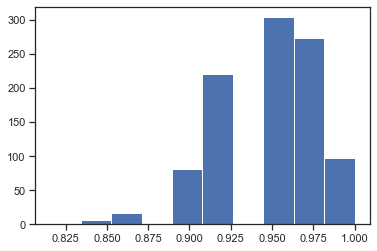

In [43]:
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)

It's obviously a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as overfitting: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

# Cross-validation

This problem is the main reason that most data scientists perform <b>k-fold cross-validation</b> on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 10-fold cross-validation on our data set looks something like this:

(each square is an entry in our data set)

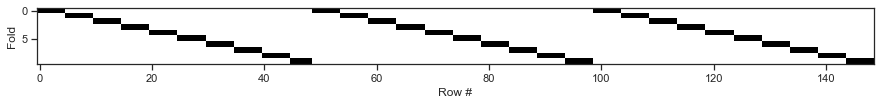

In [44]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

You'll notice that we used <b>Stratified k-fold cross-validation</b> in the code above. Stratified k-fold keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set. (e.g., so we don't have 100% Iris setosa entries in one of the folds.)

We can perform 10-fold cross-validation on our model with the following code:

Text(0.5, 1.0, 'Average score: 0.96')

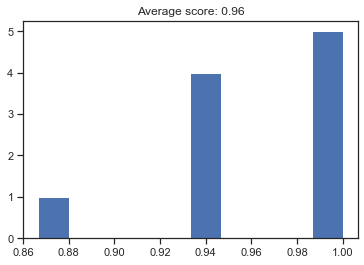

In [45]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

# Parameter tuning

Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

Text(0.5, 1.0, 'Average score: 0.6642857142857144')

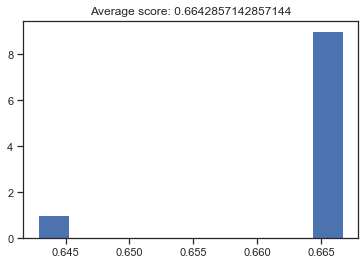

In [46]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

the classification accuracy falls tremendously.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is <b>Grid Search</b>. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [47]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.959731543624161
Best parameters: {'max_depth': 2, 'max_features': 3}


C:\Users\mk978k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now let's visualize the grid search to see how the parameters interact.

''

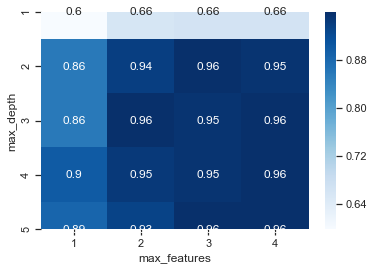

In [48]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

Now we have a better sense of the parameter space: We know that we need a max_depth of at least 2 to allow the decision tree to make more than a one-off decision.

max_features doesn't really seem to make a big difference here as long as we have 2 of them, which makes sense since our data set has only 4 features and is relatively easy to classify. (Remember, one of our data set's classes was easily separable from the rest based on a single feature.)

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [63]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9664429530201343
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'splitter': 'random'}


C:\Users\mk978k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now we can take the best classifier from the Grid Search and use that:

In [64]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

We can even visualize the decision tree with GraphViz to see how it's making the classifications:

In [70]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('iris_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

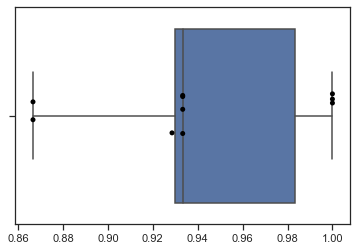

In [71]:
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)

sb.boxplot(dt_scores)
sb.stripplot(dt_scores, jitter=True, color='black')

How about we compare another classifier to see how they perform?

We already know from previous projects that <b>Random Forest</b> classifiers usually work better than individual decision trees. A common problem that decision trees face is that they're prone to overfitting: They complexify to the point that they classify the training set near-perfectly, but fail to generalize to data they have not seen before.

<b>Random Forest classifiers</b> work around that limitation by creating a whole bunch of decision trees (hence "forest") — each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) — and have the decision trees work together to make a more accurate classification.

Let that be a lesson for us: <b>Even in Machine Learning, we get better results when we work together!</b>

Let's see if a Random Forest classifier works better here.

The great part about scikit-learn is that the training, testing, parameter tuning, etc. process is the same for all models, so we only need to plug in the new classifier.

In [72]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.9664429530201343
Best parameters: {'criterion': 'gini', 'max_features': 3, 'n_estimators': 100}


C:\Users\mk978k\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Now we can compare their performance:

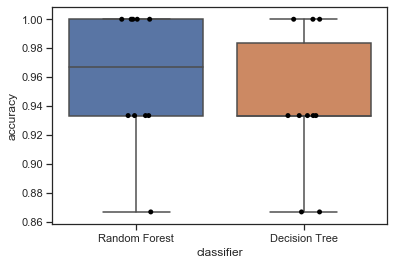

In [73]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')

How about that? They both seem to perform about the same on this data set. This is probably because of the limitations of our data set: We have only 4 features to make the classification, and Random Forest classifiers excel when there's hundreds of possible features to look at. In other words, there wasn't much room for improvement with this data set.

# Reproducibility

Ensuring that our work is reproducible is the last and — arguably — most important step in any analysis. <b>As a rule, we shouldn't place much weight on a discovery that can't be reproduced.</b> As such, if our analysis isn't reproducible, we might as well not have done it.

Notebooks like this one go a long way toward making our work reproducible. Since we documented every step as we moved along, we have a written record of what we did and why we did it — both in text and code.

Beyond recording what we did, we should also document what software and hardware we used to perform our analysis. This typically goes at the top of our notebooks so our readers know what tools to use.

Finally, let's extract the core of our work from Steps 1-5 and turn it into a single pipeline.

[4.8  3.4  1.6  0.25]	-->	Iris-setosa	(Actual: Iris-setosa)
[7.1 3.  5.9 2.1]	-->	Iris-virginica	(Actual: Iris-virginica)
[7.  3.2 4.7 1.4]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[4.4 3.  1.3 0.2]	-->	Iris-setosa	(Actual: Iris-setosa)
[6.9 3.1 5.4 2.1]	-->	Iris-virginica	(Actual: Iris-virginica)
[6.2 2.8 4.8 1.8]	-->	Iris-versicolor	(Actual: Iris-virginica)
[6.2 3.4 5.4 2.3]	-->	Iris-virginica	(Actual: Iris-virginica)
[4.8 3.4 1.9 0.2]	-->	Iris-setosa	(Actual: Iris-setosa)
[4.9 2.4 3.3 1. ]	-->	Iris-versicolor	(Actual: Iris-versicolor)
[6.5 2.8 4.6 1.5]	-->	Iris-versicolor	(Actual: Iris-versicolor)


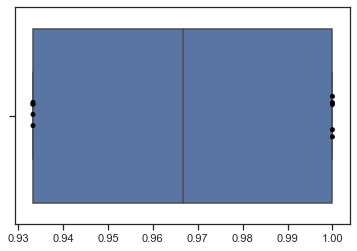

In [75]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# We can jump directly to working with the clean data because we saved our cleaned data set
iris_data_clean = pd.read_csv('iris-data-clean.csv')

# Testing our data: Our analysis will stop here if any of these assertions are wrong

# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3

# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data_clean.loc[iris_data_clean['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

all_inputs = iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values

all_labels = iris_data_clean['class'].values

# This is the classifier that came out of Grid Search
random_forest_classifier = RandomForestClassifier(criterion='gini', max_features=3, n_estimators=50)

# All that's left to do now is plot the cross-validation scores
rf_classifier_scores = cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10)
sns.boxplot(rf_classifier_scores)
sns.stripplot(rf_classifier_scores, jitter=True, color='black')

# ...and show some of the predictions from the classifier
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)

random_forest_classifier.fit(training_inputs, training_classes)

for input_features, prediction, actual in zip(testing_inputs[:10],
                                              random_forest_classifier.predict(testing_inputs[:10]),
                                              testing_classes[:10]):
    print('{}\t-->\t{}\t(Actual: {})'.format(input_features, prediction, actual))